In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
import os,random
import keras
#os.environ["KERAS_BACKEND"] = "theano"

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICE"]  = '0'
#os.environ["THEANO_FLAGS"]  = "floatX=float32"
#os.environ["THEANO_FLAGS"]  = "device=cuda%d"%(1)

Using TensorFlow backend.


In [2]:
import numpy as np
import seaborn as sns
import pickle, random, sys

In [3]:
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
#from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam
#import theano as th
#import theano.tensor as T
import os
WEIGHTS_PATH = ('resnet_like_weights_tf_dim_ordering_tf_kernels.h5')
from keras.models import Model
from keras.layers import Input,Dense,Conv1D,MaxPool1D,ReLU,Dropout,Softmax
from keras.layers import LSTM
import keras
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
import tensorflow as tf
import importlib,sys

importlib.reload(sys)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Load the dataset ...
#  You will need to seperately download or generate this file
dbfile = open('RML2016.10a_dict.dat', 'rb')      
Xd = pickle.load(dbfile,encoding='latin1') 
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [4]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.9)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [5]:
print('数据集总数：',n_examples)
print('调制方式' , len(mods),'种:' ,mods)
print('信噪比:',snrs)

数据集总数： 220000
调制方式 11 种: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
信噪比: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [6]:
X_train_feature_expert = pd.read_csv('X_train_feature_expert.csv',header=None).drop(columns=[0],index=[0])
X_test_feature_expert = pd.read_csv('X_test_feature_expert.csv',header=None).drop(columns=[0],index=[0])

X_train_feature_time = pd.read_csv('X_train_feature_time.csv',header=None).drop(columns=[0],index=[0])
X_test_feature_time = pd.read_csv('X_test_feature_time.csv',header=None).drop(columns=[0],index=[0])

X_train_feature_old = pd.read_csv('X_train_feature_old.csv',header=None).drop(columns=[0],index=[0])
X_test_feature_old = pd.read_csv('X_test_feature_old.csv',header=None).drop(columns=[0],index=[0])

In [46]:
X_train_feature = X_train_feature_time
X_test_feature = X_test_feature_time

print(X_train_feature.shape)
print(X_test_feature.shape)

# standardize the features

from sklearn.feature_selection import VarianceThreshold
X_all = np.concatenate((X_train_feature, X_test_feature), axis = 0)

s0 = X_train_feature.shape[0]
s1 = X_train_feature.shape[1]

k = 1
interval = int(s1/k)
X_train_std_all_list = []
X_test_std_list = []
sc_train = []
for i in range(k):
    X_all_filter = VarianceThreshold(threshold=(0)).fit_transform(X_all[:,interval*i: interval*(i+1)])
    sc_train.append(StandardScaler())
    print(X_all_filter.shape)
    sc_train[i].fit(X_all_filter)
    X_train_std_all_list.append(sc_train[i].transform(X_all_filter[:s0,:])) 
    X_test_std_list.append(sc_train[i].transform(X_all_filter[s0:,:]))
X_train_std_all = np.concatenate((X_train_std_all_list), axis = 1)
X_test_std = np.concatenate((X_test_std_list), axis = 1)

print("X_train_std_all,", X_train_std_all.shape)
print("X_test_std,", X_test_std.shape)

(198000, 132)
(22000, 132)
(220000, 127)
X_train_std_all, (198000, 127)
X_test_std, (22000, 127)


In [47]:
# devide train and val data
from sklearn.model_selection import train_test_split
X_train_std, X_val_std, y_train, y_val = train_test_split(X_train_std_all, Y_train, test_size=0.111, random_state=42)
print("X_train_std,", X_train_std.shape)
print("X_val_std,", X_val_std.shape)
print("X_test_std,", X_test_std.shape)

X_train_std, (176022, 127)
X_val_std, (21978, 127)
X_test_std, (22000, 127)


In [48]:
X_train_std = pd.DataFrame(X_train_std)
X_val_std = pd.DataFrame(X_val_std)
X_test_std = pd.DataFrame(X_test_std)

In [49]:
# inf,nan数据填充
X_train_std = (X_train_std.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 
X_val_std = (X_val_std.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 
X_test_std = (X_test_std.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 

In [50]:
X_train_std.shape,X_test_std.shape

((176022, 127), (22000, 127))

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
 
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Dropout
 
import matplotlib.pyplot as plt
import pandas as pd

In [52]:
x_train = X_train_std.values
x_test = X_test_std.values
x_val = X_val_std.values

In [53]:
# reshape 2D to 3D ->  x_train.reshape(num_of_examples,num_of_features,num_of_signals)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

In [54]:
x_train.shape,x_test.shape,x_val.shape,y_train.shape,Y_test.shape,y_val.shape

((176022, 127, 1),
 (22000, 127, 1),
 (21978, 127, 1),
 (176022, 11),
 (22000, 11),
 (21978, 11))

In [55]:
# build CNN model
model = Sequential()
model.add(Conv1D(64, 3, input_shape=(127, 1),activation='relu'))  # convolution
model.add(MaxPool1D(pool_size=2))  # pooling

model.add(Conv1D(64, 3,activation='relu'))  # convolution
model.add(MaxPool1D(pool_size=2))  # pooling

model.add(Flatten())  # flatten
model.add(Dense(128, activation='relu'))  # fc
model.add(Dropout(0.5))  # dropout
model.add(Dense(11, activation='softmax'))
 
# model compile
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 125, 64)           256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 60, 64)            12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               245888    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [56]:
# model training
# Set up some params 
nb_epoch = 200   # number of epochs to train on
batch_size = 1024  # training batch size

def scheduler(epoch):
    print("epoch({}) lr is {}".format(epoch, K.get_value(model.optimizer.lr)))
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

filepath = 'CNN_dr0.5.h5'
history = model.fit(x_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=1,
    validation_data=(x_val,y_val),
    callbacks = [reduce_lr,
                keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,patince=3,min_lr=0.000001),
                keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
                ]
                    )

Train on 176022 samples, validate on 21978 samples
epoch(0) lr is 0.0010000000474974513
Epoch 1/200
174080/176022 [============================>.] - ETA: 0s - loss: 2.4084 - accuracy: 0.0956
Epoch 00001: val_loss improved from inf to 2.39505, saving model to CNN_dr0.5.h5
176022/176022 [==============================] - 3s 19us/sample - loss: 2.4083 - accuracy: 0.0957 - val_loss: 2.3951 - val_accuracy: 0.1039
epoch(1) lr is 0.0010000000474974513
Epoch 2/200
171008/176022 [============================>.] - ETA: 0s - loss: 2.3997 - accuracy: 0.1016
Epoch 00002: val_loss improved from 2.39505 to 2.38719, saving model to CNN_dr0.5.h5
176022/176022 [==============================] - 2s 11us/sample - loss: 2.3997 - accuracy: 0.1019 - val_loss: 2.3872 - val_accuracy: 0.1157
epoch(2) lr is 0.0010000000474974513
Epoch 3/200
173056/176022 [============================>.] - ETA: 0s - loss: 2.3910 - accuracy: 0.1085
Epoch 00003: val_loss improved from 2.38719 to 2.37936, saving model to CNN_dr0.5.h

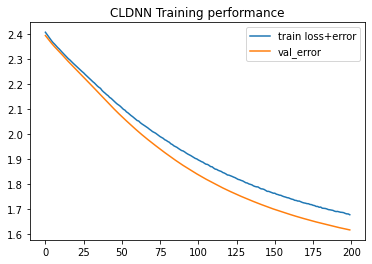

In [57]:
# Show loss curves 
plt.figure()
plt.title('CLDNN Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.savefig('pic\Loss_Curve\AP_CLDNN_LOSS.jpg',dpi = 300)

In [58]:
def plot_confusion_matrix(cm, title='AP-based Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

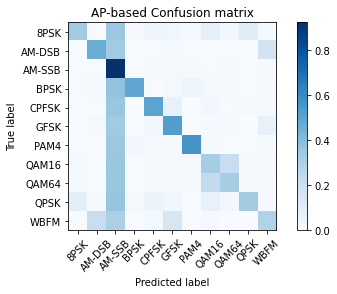

In [59]:
# Plot confusion matrix
classes = mods
test_Y_hat = model.predict(x_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,x_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
plt.savefig('pic\Confusion_Matrix\AP_CM_CLDNN.jpg',dpi = 300)

In [60]:
# model0:原模型测试
classes = mods
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = x_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]   
    #print(test_X_i)
    test_Y_i_hat = model.predict(test_X_i)
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    #print("Overall Accuracy: ", cor / (cor+ncor))
    print(cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

0.0998185117967332
0.09435707678075855
0.10603290676416818
0.06835205992509363
0.12302284710017575
0.08602150537634409
0.11707317073170732
0.18588025022341376
0.33524904214559387
0.46944198405668736
0.5547576301615799
0.6449864498644986
0.7399103139013453
0.7619877942458587
0.7889990982867449
0.7926829268292683
0.8051146384479718
0.800185873605948
0.773308957952468
0.7959001782531194


In [61]:
model.save("model_saved\Feat_based\CNN_time_200.h5")

# RBFNN

In [127]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])

In [128]:
x_train.shape,x_test.shape,x_val.shape,y_train.shape,y_test.shape,y_val.shape

((176022, 152), (22000, 152), (21978, 152), (176022, 11), (50, 3), (21978, 11))

In [129]:
import rbflayer, kmeans_initializer
rbflayer.RBFLayer

rbflayer.RBFLayer

In [130]:
# pip install keras
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from keras import layers

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 4), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [17]:
# history_rbf = []
# dr = 0.5

# RBF = rbflayer.RBFLayer(100,
#                       initializer=kmeans_initializer.InitCentersKMeans(x_train),
#                       #initializer=InitCentersRandom(X_smo),
#                       betas=5.0,
#                       input_shape=([x_train.shape[1]]))

# model = keras.models.Sequential()
# model.add(RBF)
# model.add(layers.Dense(128,activation='selu',name='fc1'))
# model.add(Dropout(dr))
# model.add(layers.Dense(128,activation='selu',name='fc2'))
# model.add(Dropout(dr))
# model.add(layers.Dense(11,activation = 'softmax'))

# # model compile
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])
# model.summary()

# filepath = 'RBF_dr0.5.h5'
# history = model.fit(x_train, y_train,
#                    epochs = 100,
#                    batch_size = 1024,
#                    validation_data = (x_val,y_val),
#                    callbacks = [reduce_lr, 
#                                 keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
#                                 keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,patince=3,min_lr=0.000001),
#                                 keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
#                                ]
#                    )

# history_rbf.append(history)